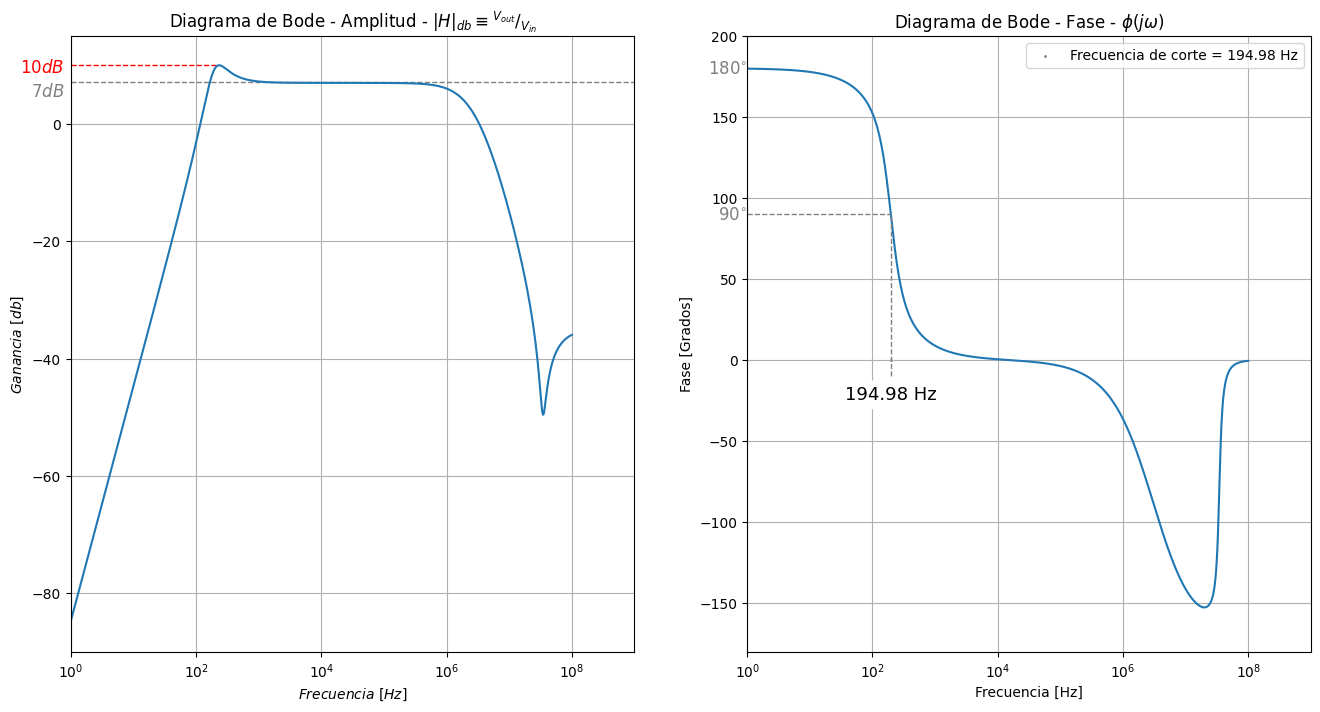

In [5]:
import ltspice
import numpy as np
import matplotlib.pyplot as plt
import os


OMEGA_D = 73.84
ALPHA = 0.19
OMEGA = 85.31
XI = 0.5

# ----------------------------     Graficos del circuito con valores fijos     --------------------------------------


#------------Load the signals from the .raw file
raw_file = 'BODE\\Simulacion_bode.raw'
l = ltspice.Ltspice(raw_file) 
# Make sure that the .raw file is located in the correct path
l.parse()
#-----------------------------------------------

#Parameters for the circuit
Fs = 2.5
Ts = 1/Fs

#----------------------------Obtain basic signals
frequency = l.get_frequency()
Vout = l.get_data('V(vout)')
Vin = l.get_data('V(vin)')
VoutDB = 20 * np.log10(Vout / Vin)
phase = np.angle(Vout, deg = True)
# Buscar el índice donde la fase es cercana a 90 grados
index90 = np.abs(phase - 90).argmin()
frequency90 = frequency[index90]
#-------------------------------------------------


#Set max and min Voltages and currents
frequency_begin = 1
frequency_end = 100E7
gain_begin = -90
gain_end = 15


# Module plot
fig = plt.figure(figsize=(16,8))
plt.subplot(1, 2, 1)
plt.axhline(y = 7.05, linestyle='--', linewidth = 1,color='grey')
plt.text(1, 7.05, r"$7dB$  ", ha='right', va='top', rotation='horizontal', color = 'grey', fontsize = 12)
plt.plot([1, 210], [10, 10], linestyle = '--', linewidth = 1,  color = 'red')
plt.text(1, 8, r"$10dB$  ", ha='right', va='bottom', rotation='horizontal', color = 'red', fontsize = 12)
plt.semilogx(frequency, VoutDB)
plt.title("Diagrama de Bode - Amplitud - $|H|_{db} \equiv  ^{V_{out}}/_{V_{in}}$")       #title
plt.xlabel("$Frecuencia\ [Hz]$")
plt.ylabel("$Ganancia\ [db]$")

plt.xlim(frequency_begin, frequency_end)
plt.ylim(gain_begin, gain_end)
plt.grid()

# Fase plot
plt.subplot(1, 2, 2)
plt.semilogx(frequency, phase)
plt.text(1, 180, r"$180^{\circ}$", ha='right', va='center', rotation='horizontal', color = 'grey', fontsize = 12)
plt.plot([frequency90, frequency90], [-10, 90], linestyle = '--', linewidth = 1,  color = 'grey')
plt.plot([1, frequency90], [90, 90], linestyle = '--', linewidth = 1,  color = 'grey')
plt.annotate("{:.2f}".format(frequency90) + " Hz", xy=(frequency90, -10), xytext=(0, -17),textcoords='offset points', ha='center', fontsize = 13, bbox=dict(boxstyle='round', facecolor='white', edgecolor='none'))
plt.text(1, 90, r"$90 ^{\circ}$", ha='right', va='center', rotation='horizontal', color = 'grey', fontsize = 12)
plt.scatter(frequency90, 0, color='grey', s = 1, label='Frecuencia de corte = ' + "{:.2f}".format(frequency90) + " Hz")
plt.xlabel('Frecuencia [Hz]')
plt.ylabel('Fase [Grados]')
plt.xlim(frequency_begin, frequency_end)
plt.ylim(-180, 200)
plt.grid(True)
plt.legend()
plt.title("Diagrama de Bode - Fase - $ \phi (j \omega) $")

#plt.savefig('Bode Altium.pdf', format='pdf')
plt.show()


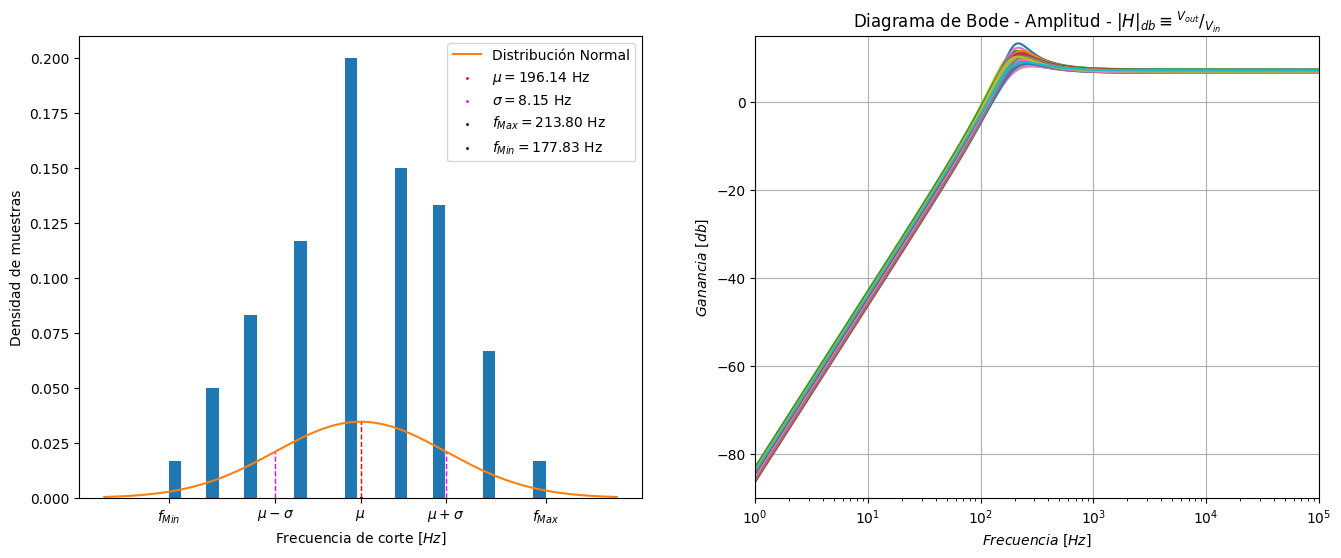

In [33]:
import ltspice
import numpy as np
import matplotlib.pyplot as plt
import os


# ----------------------------     Graficos del circuito con valores fijos     --------------------------------------


#------------Load the signals from the .raw file
raw_file = 'MONTECARLO\\Simulacion_Analisis_de_Montecarlo.raw'
l = ltspice.Ltspice(raw_file) 
# Make sure that the .raw file is located in the correct path
l.parse()
#-----------------------------------------------

#----------------------------Obtain basic signals

cutOffFrequencies = []


for i in range(l.case_count): # Iteration in simulation cases 
    frequency = l.get_frequency(i)
    Vout = l.get_data('V(vout)', i)
    Vin = l.get_data('V(vin)', i)
    VoutDB = 20 * np.log10(Vout / Vin)
    phase = np.angle(Vout, deg = True)
    
    # Buscar el índice donde la fase es cercana a 90 grados
    index90 = np.abs(phase - 90).argmin()
    frequency90 = frequency[index90]
    cutOffFrequencies.append(frequency90)

#-------------------------------------------------

fig = plt.figure(figsize=(16,6))

# Histograma
plt.subplot(1, 2, 1)

counts, bins, _ = plt.hist(cutOffFrequencies, bins = 30, density = True)

# Calcula la media y la desviación estándar
media = (1/l.case_count) * np.sum(cutOffFrequencies)
str_media = "{:.2f}".format(media)
desvio = np.sqrt((1/(l.case_count -1)) * np.sum((cutOffFrequencies - media) ** 2))
str_desvio = "{:.2f}".format(desvio)
t = np.linspace(media - desvio * 3, media + desvio * 3, 1000)
dist_normal = (1/(desvio * 2 * np.sqrt(np.pi))) * np.exp(-(t-media)**2/(2*desvio**2))
plt.plot(t, dist_normal, label = 'Distribución Normal')


UNIDADES_LEYENDA = " Hz"

# Anotaciones
plt.plot([media, media], [0, (1/(desvio * 2 * np.sqrt(np.pi)))], linestyle = '--', linewidth = 1,  color = 'red')
plt.scatter(media, 0, color='red', s = 1, label='$\mu = $' + str_media + UNIDADES_LEYENDA)
x_ticks = [media, media + desvio, media - desvio, max(cutOffFrequencies), min(cutOffFrequencies)]
x_labels = ["$\mu$", "$\mu + \sigma$", "$\mu - \sigma$", "$f_{Max}$", "$f_{Min}$"]
plt.xticks(x_ticks, x_labels)
plt.plot([media - desvio, media - desvio], [0, (1/(desvio * 2 * np.sqrt(np.pi))) * np.exp(-desvio**2/(2*desvio**2))], linestyle = '--', linewidth = 1,  color = 'magenta')
plt.plot([media + desvio, media + desvio], [0, (1/(desvio * 2 * np.sqrt(np.pi))) * np.exp(-desvio**2/(2*desvio**2))], linestyle = '--', linewidth = 1,  color = 'magenta')
plt.scatter(media, 0, color='magenta', s = 1, label='$\sigma = $' + str_desvio + UNIDADES_LEYENDA)
plt.scatter(media, 0, color='black', s = 1, label='$f_{Max} = $' + "{:.2f}".format(max(cutOffFrequencies)) + UNIDADES_LEYENDA)
plt.scatter(media, 0, color='black', s = 1, label='$f_{Min} = $' + "{:.2f}".format(min(cutOffFrequencies)) + UNIDADES_LEYENDA)

plt.xlabel("Frecuencia de corte $[Hz]$")
plt.ylabel("Densidad de muestras")

plt.legend()


plt.subplot(1, 2, 2)

frequency_begin = 1
frequency_end = 100E3
gain_begin = -90
gain_end = 15

# Module plot
for i in range(l.case_count): # Iteration in simulation cases 
    frequency = l.get_frequency(i)
    Vout = l.get_data('V(vout)', i)
    Vin = l.get_data('V(vin)', i)
    VoutDB = 20 * np.log10(Vout / Vin)
    plt.semilogx(frequency, VoutDB)
plt.title("Diagrama de Bode - Amplitud - $|H|_{db} \equiv  ^{V_{out}}/_{V_{in}}$")       #title
plt.xlabel("$Frecuencia\ [Hz]$")
plt.ylabel("$Ganancia\ [db]$")

plt.xlim(frequency_begin, frequency_end)
plt.ylim(gain_begin, gain_end)
plt.grid()

#plt.savefig('Histograma Frecuencia de corte.pdf', format='pdf')

plt.show()